In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
import warnings

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

In [3]:
# Loading datasets
alzheimers_data = pd.read_csv('/kaggle/input/alzheimers-disease-data/alzheimers_disease_data.csv')
longitudinal_data = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_longitudinal.csv')
cross_sectional_data = pd.read_csv('/kaggle/input/mri-and-alzheimers/oasis_cross-sectional.csv')

In [4]:
# Exploratory Data Analysis (EDA)
print(longitudinal_data.info())
print(longitudinal_data.describe())

print(cross_sectional_data.info())
print(cross_sectional_data.describe())

print(alzheimers_data.info())
print(alzheimers_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB
None
            Visit     MR Delay         Age        EDUC         SES  \
count  373.000000   373.000000  373.000000  373.000000  354.

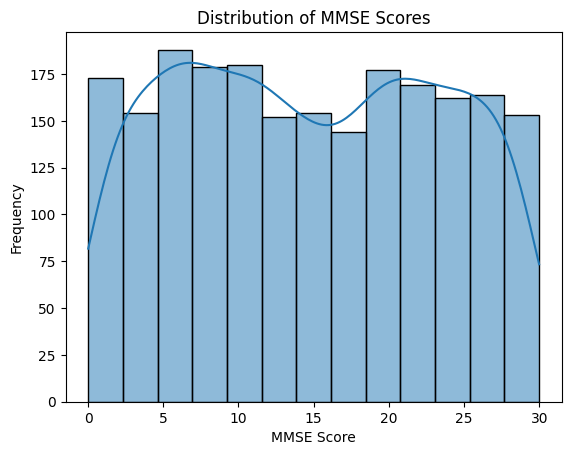

In [5]:
# Replace infinite values with NaN and drop them
alzheimers_data.replace([np.inf, -np.inf], np.nan, inplace=True)
alzheimers_data.dropna(subset=['MMSE'], inplace=True)

# Plotting the MMSE Score distribution
sns.histplot(alzheimers_data['MMSE'], kde=True)
plt.title('Distribution of MMSE Scores')
plt.xlabel('MMSE Score')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Data Preprocessing
# Handle Missing Values: Fill NaNs with median values (only for numeric columns)
numeric_cols_longitudinal = longitudinal_data.select_dtypes(include=['number']).columns
numeric_cols_cross_sectional = cross_sectional_data.select_dtypes(include=['number']).columns
numeric_cols_alzheimers = alzheimers_data.select_dtypes(include=['number']).columns

longitudinal_data[numeric_cols_longitudinal] = longitudinal_data[numeric_cols_longitudinal].fillna(longitudinal_data[numeric_cols_longitudinal].median())
cross_sectional_data[numeric_cols_cross_sectional] = cross_sectional_data[numeric_cols_cross_sectional].fillna(cross_sectional_data[numeric_cols_cross_sectional].median())
alzheimers_data[numeric_cols_alzheimers] = alzheimers_data[numeric_cols_alzheimers].fillna(alzheimers_data[numeric_cols_alzheimers].median())

In [7]:
# Handle Infinite Values: Replace inf with NaN and then fill with median values
longitudinal_data.replace([np.inf, -np.inf], np.nan, inplace=True)
cross_sectional_data.replace([np.inf, -np.inf], np.nan, inplace=True)
alzheimers_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [8]:
# Encoding Categorical Data
# Convert categorical columns such as 'Group', 'Gender', etc., to numerical codes
longitudinal_data['Group'] = longitudinal_data['Group'].astype('category').cat.codes
cross_sectional_data['M/F'] = cross_sectional_data['M/F'].astype('category').cat.codes
alzheimers_data['Gender'] = alzheimers_data['Gender'].astype('category').cat.codes

In [9]:
# Merging the longitudinal and cross-sectional datasets using the correct identifiers
merged_data = pd.merge(longitudinal_data, cross_sectional_data, left_on='Subject ID', right_on='ID', how='outer')

In [10]:
# Defining Features and Target for Model Building
# Update: Use Label Encoding for the Target variable (Demented/Nondemented)
label_encoder = LabelEncoder()

In [11]:
# Assuming the column 'Diagnosis' in 'alzheimers_data' indicates dementia status
merged_data['Diagnosis'] = label_encoder.fit_transform(merged_data['Group'])  # Adjusted based on 'Group' column

X = merged_data.drop(['Diagnosis', 'Subject ID', 'MRI ID', 'ID'], axis=1, errors='ignore')  # Adjust columns to drop based on dataset
y = merged_data['Diagnosis']  # Target variable

In [12]:
# One-Hot Encoding for other categorical columns
X = pd.get_dummies(X, drop_first=True)

In [13]:
# Impute Missing Values before Splitting the Data
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

# Now, Split the Data into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building: Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)  # Train the model with updated, imputed X_train

RandomForestClassifier(random_state=42)

In [14]:
# Model Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
print(f"AUC: {auc:.2f}")

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.97      1.00      0.99        35
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        94

    accuracy                           0.99       162
   macro avg       0.99      0.97      0.98       162
weighted avg       0.99      0.99      0.99       162

AUC: 1.00


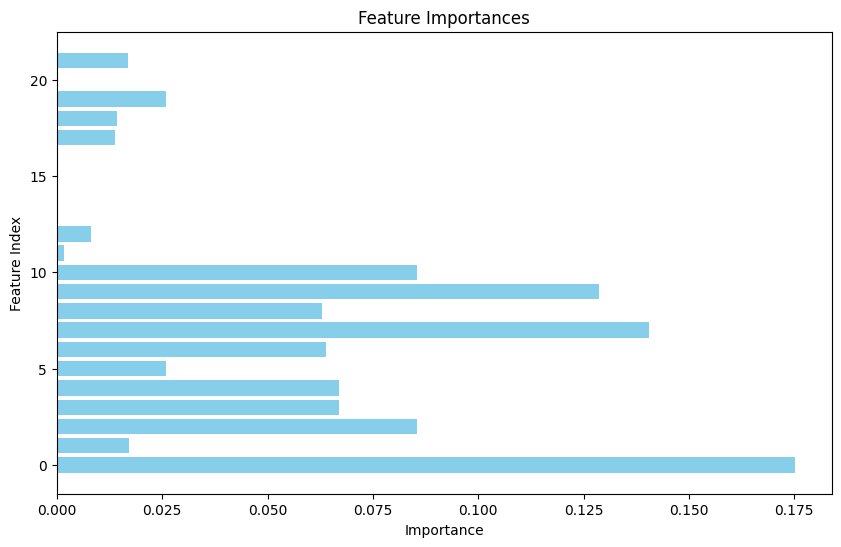

In [15]:
# Feature Importance Visualization
feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, color='skyblue')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature Index')
plt.savefig('feature_importance.png')  # Save for the poster
plt.show()

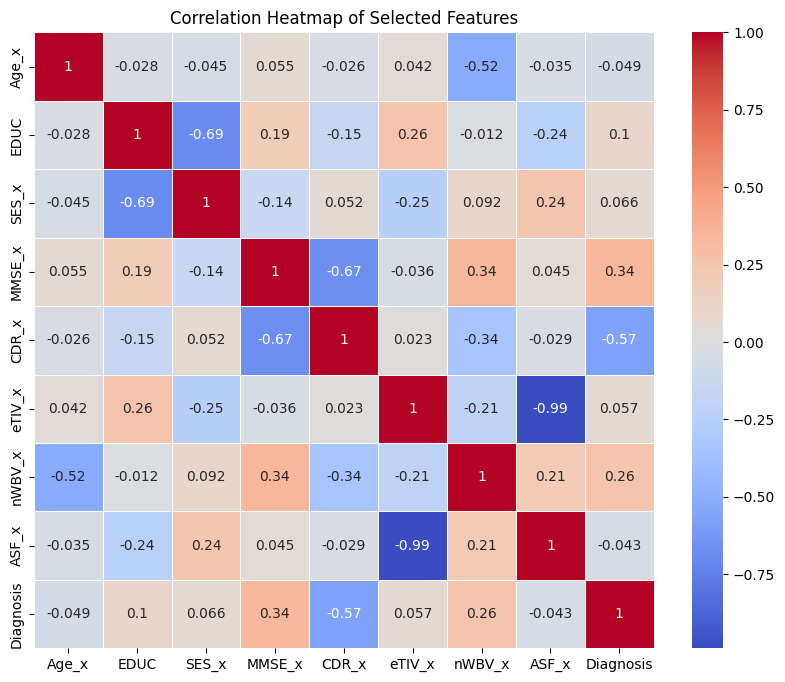

In [16]:
# Select a subset of columns that might be most relevant for analysis
selected_columns = ['Age_x', 'EDUC', 'SES_x', 'MMSE_x', 'CDR_x', 'eTIV_x', 'nWBV_x', 'ASF_x', 'Diagnosis']

# Dropping unnecessary duplicated columns (_y suffix)
selected_merged_data = merged_data[selected_columns]

# Creating a new correlation heatmap with filtered features
plt.figure(figsize=(10, 8))
filtered_corr_matrix = selected_merged_data.corr()
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Selected Features')
plt.show()

In [17]:
print(merged_data.columns)

Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F_x', 'Hand_x',
       'Age_x', 'EDUC', 'SES_x', 'MMSE_x', 'CDR_x', 'eTIV_x', 'nWBV_x',
       'ASF_x', 'ID', 'M/F_y', 'Hand_y', 'Age_y', 'Educ', 'SES_y', 'MMSE_y',
       'CDR_y', 'eTIV_y', 'nWBV_y', 'ASF_y', 'Delay', 'Diagnosis'],
      dtype='object')


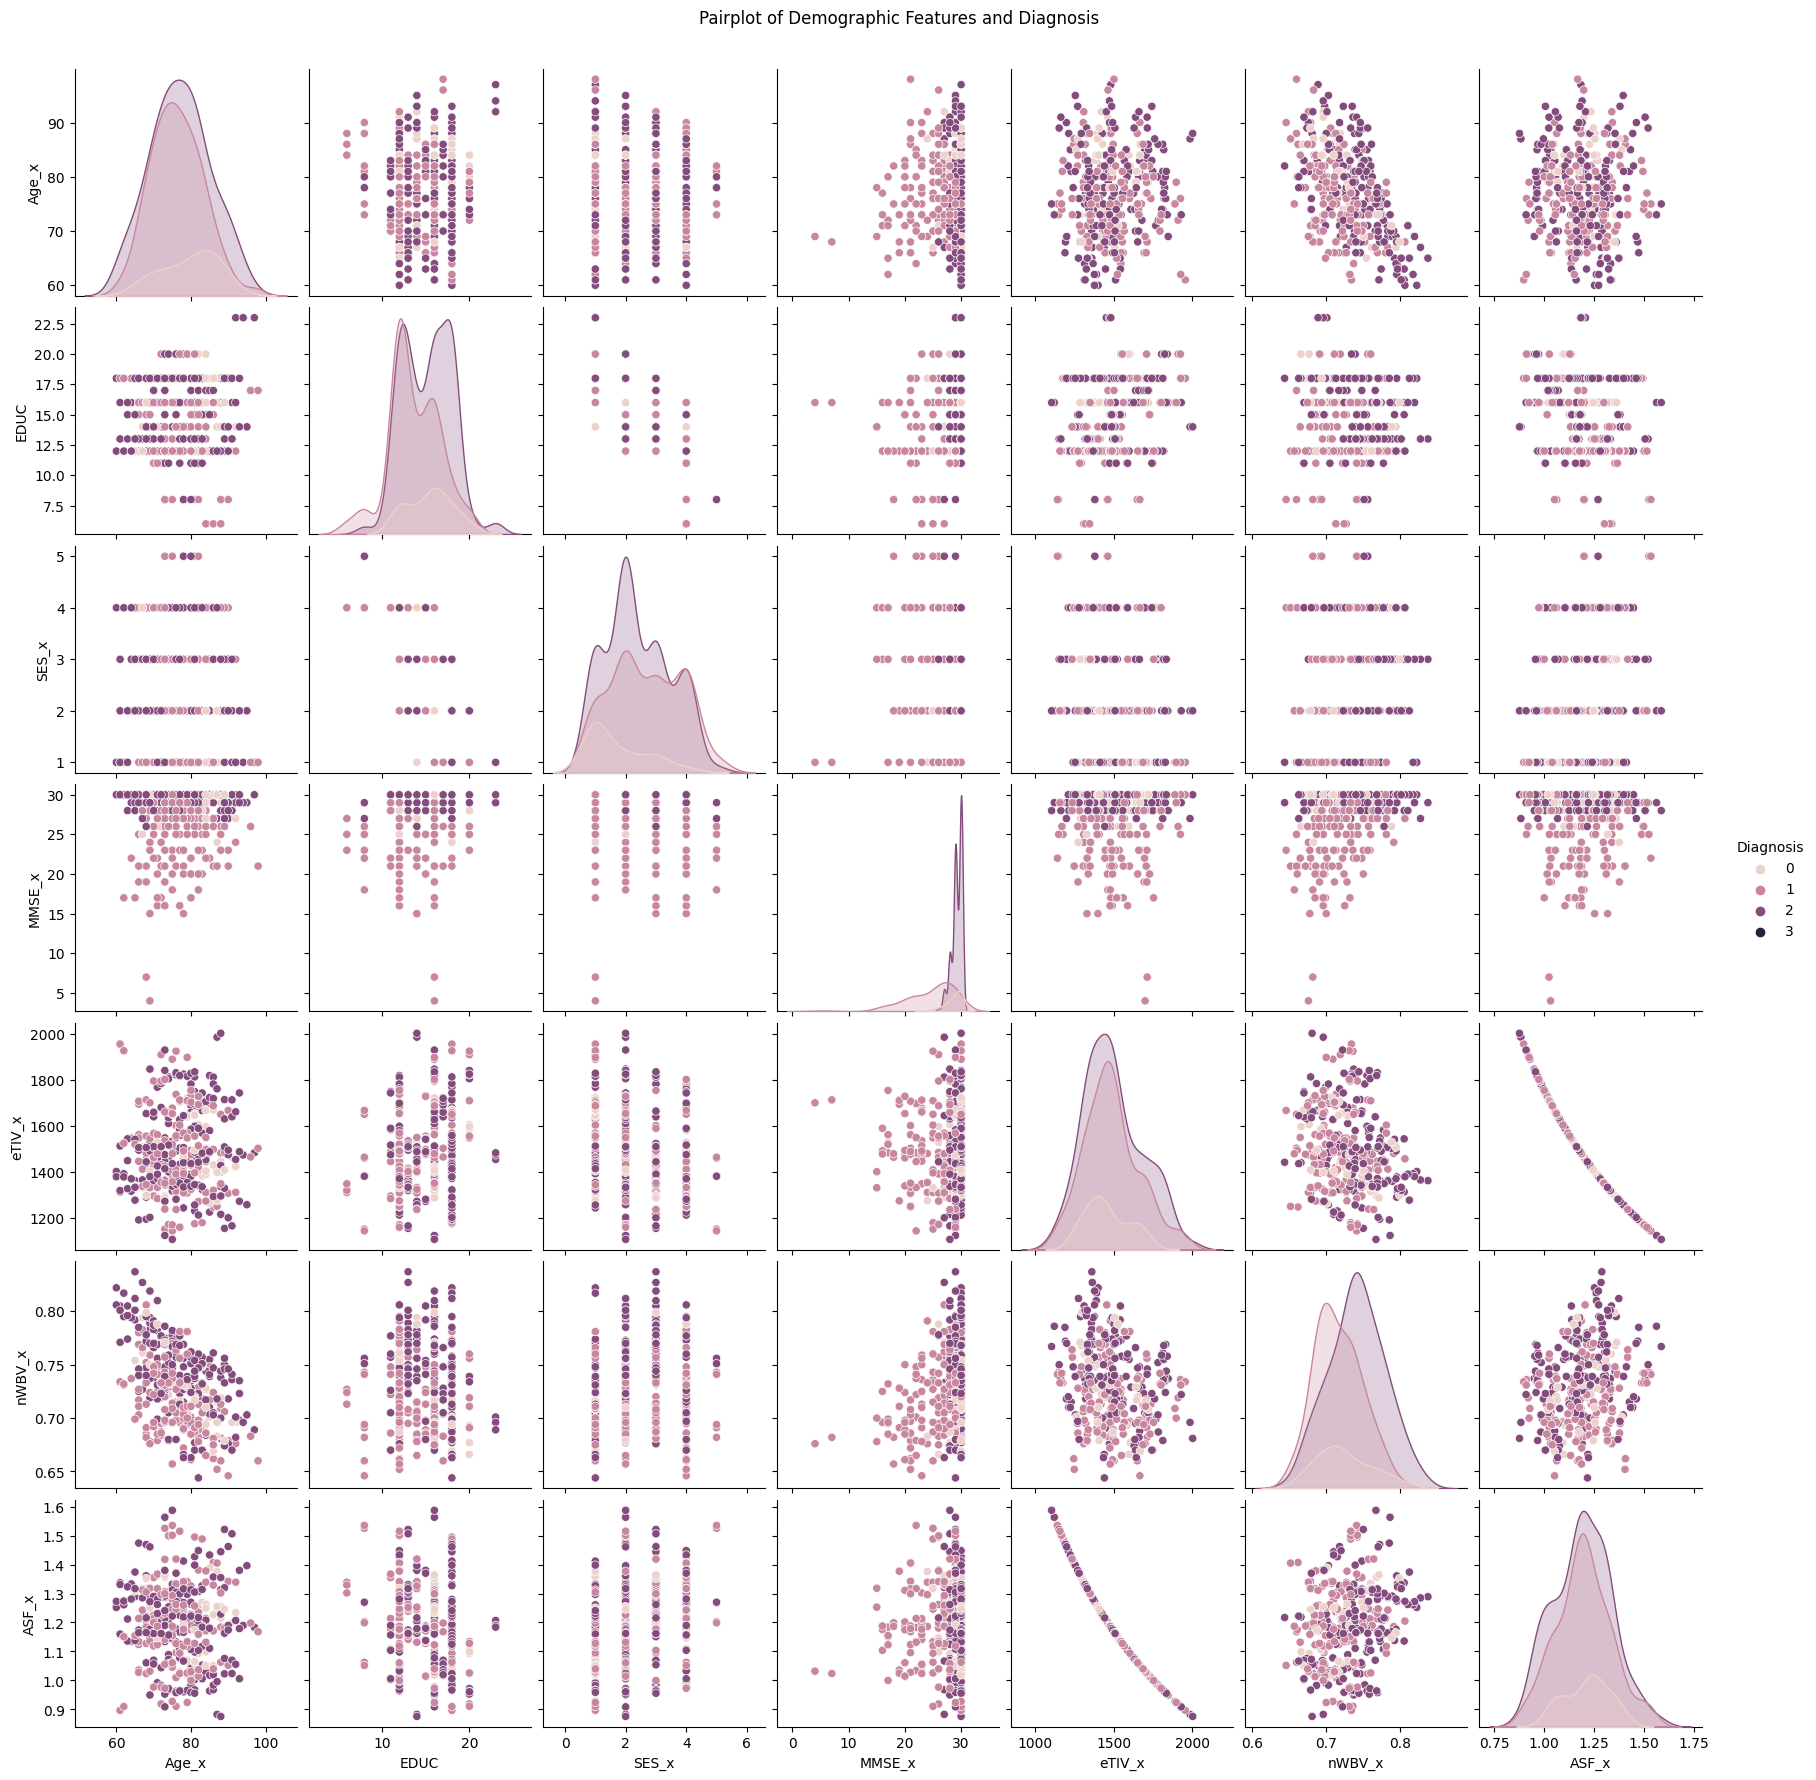

In [18]:
# Defining demographic columns based on available columns
demographic_cols = ['Age_x', 'EDUC', 'SES_x', 'MMSE_x', 'eTIV_x', 'nWBV_x', 'ASF_x', 'Diagnosis']

# Creating the pairplot for demographic analysis
sns.pairplot(merged_data[demographic_cols], hue='Diagnosis', diag_kind='kde')
plt.suptitle('Pairplot of Demographic Features and Diagnosis', y=1.02)
plt.show()

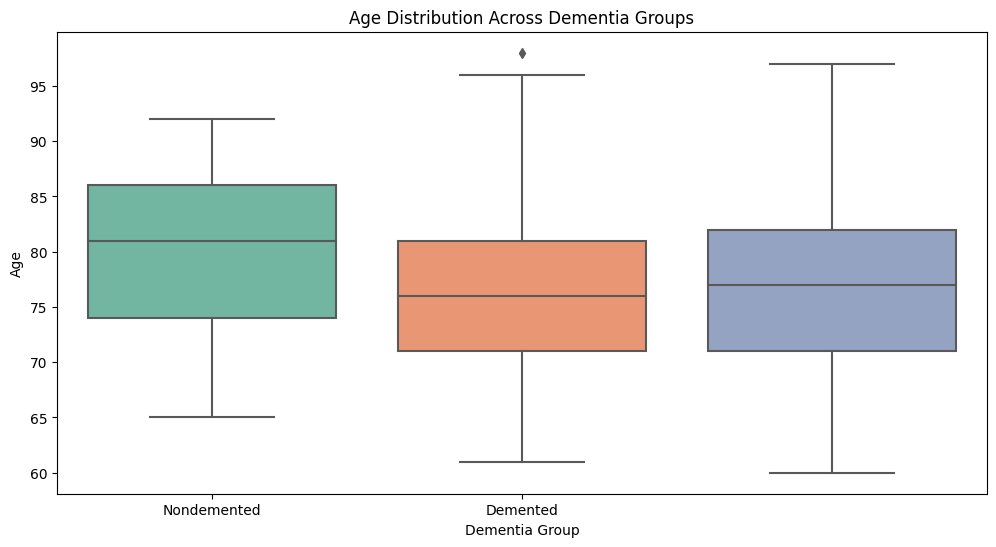

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='Age_x', data=merged_data, palette='Set2')  # Using a color palette for clarity
plt.title('Age Distribution Across Dementia Groups')
plt.xlabel('Dementia Group')
plt.ylabel('Age')
plt.xticks(ticks=[0, 1], labels=['Nondemented', 'Demented'])
plt.show()

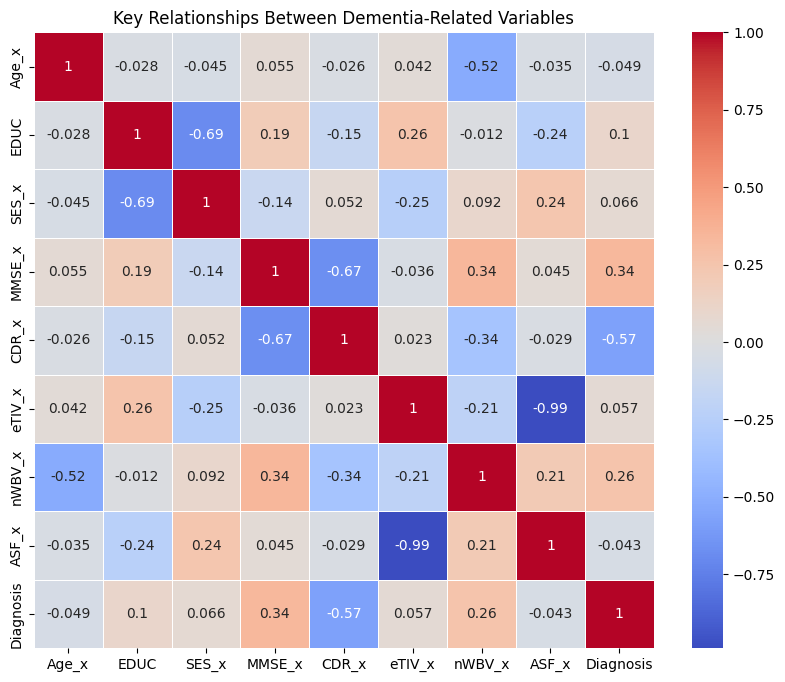

In [20]:
# Creating a new correlation heatmap with filtered features
plt.figure(figsize=(10, 8))
filtered_corr_matrix = merged_data[selected_columns].corr()
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Key Relationships Between Dementia-Related Variables')
plt.show()

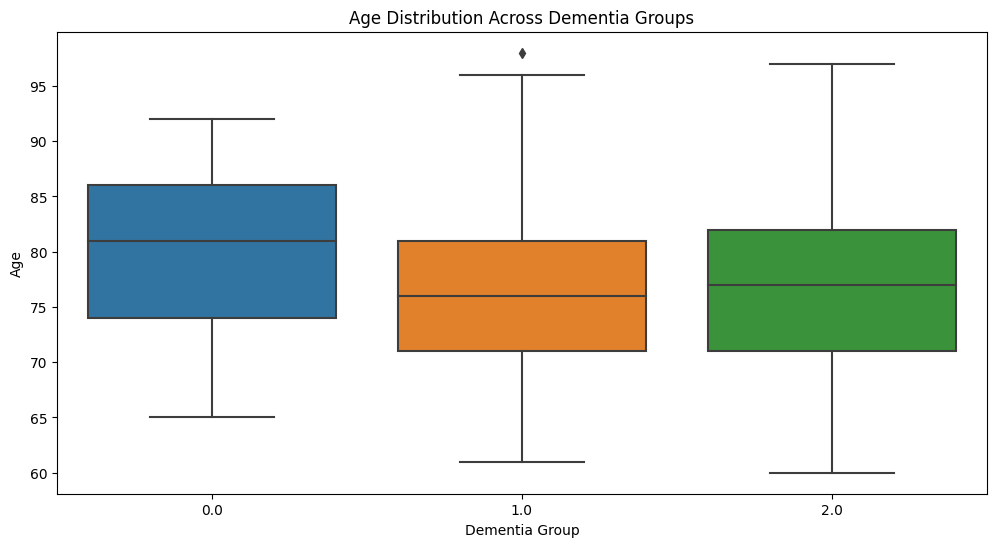

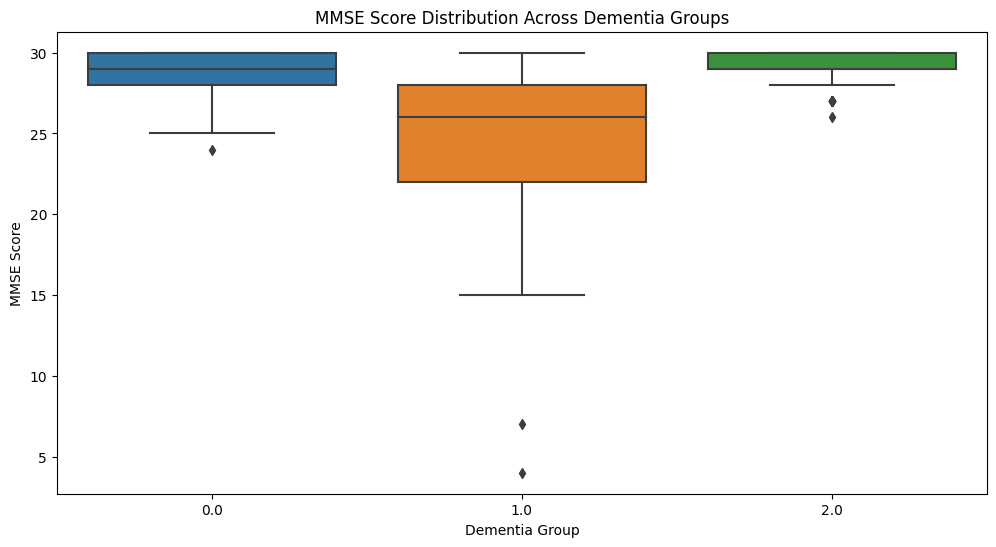

In [21]:
# Boxplot for Age vs Dementia Group
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='Age_x', data=merged_data)
plt.title('Age Distribution Across Dementia Groups')
plt.xlabel('Dementia Group')
plt.ylabel('Age')
plt.show()

# Additional Boxplot for MMSE Scores across Dementia Groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='Group', y='MMSE_x', data=merged_data)
plt.title('MMSE Score Distribution Across Dementia Groups')
plt.xlabel('Dementia Group')
plt.ylabel('MMSE Score')
plt.show()

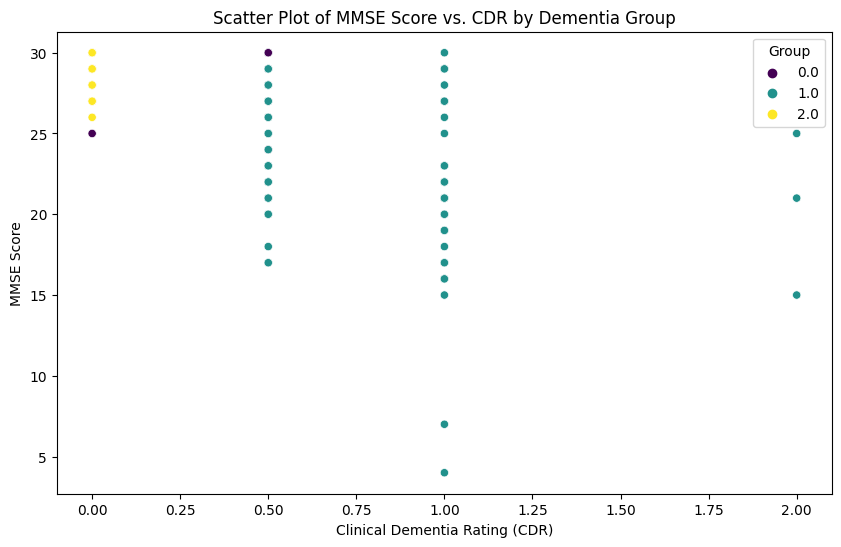

In [22]:
# Scatter Plot for MMSE vs. CDR to show their relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CDR_x', y='MMSE_x', hue='Group', data=merged_data, palette='viridis')
plt.title('Scatter Plot of MMSE Score vs. CDR by Dementia Group')
plt.xlabel('Clinical Dementia Rating (CDR)')
plt.ylabel('MMSE Score')
plt.show()